
**Building a Search Engine - Introduction**

This week we will download and run a simple version of the Google PageRank Algorithm.  Here is an early paper by Larry Page and Sergy Brin, the founders of Google, that describes their early thoughts about the algorithm:

http://infolab.stanford.edu/~backrub/google.html

We will provide you with sample code and lectures that walk through the sample code:

https://www.py4e.com/code3/pagerank.zip

There is not a lot of new code to write - it is mostly looking at the code and making the code work.  You will be able to spider some simple content that we provide and then play with the program to spider some other content.  Part of the fun of this assignment is when things go wrong and you figure out how to solve a problem when the program wanders into some data that breaks its retrieval and parsing.  So you will get used to starting over with a fresh database and running your web crawl.


**STEP 1**

-  Run filenane = spider.py

-  Selected website =  https://en.wikipedia.org/wiki/Main_Page

-  How many pages: 500

In [ ]:


# 1) Page Rank - Spidering (Chaprter 16)
# File - spider.py


import sqlite3
import urllib.error
import ssl
from urllib.parse import urljoin
from urllib.parse import urlparse
from urllib.request import urlopen
from bs4 import BeautifulSoup



# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

conn = sqlite3.connect('spider_wikipedia.sqlite')
cur = conn.cursor()

cur.execute('''CREATE TABLE IF NOT EXISTS Pages
    (id INTEGER PRIMARY KEY, url TEXT UNIQUE, html TEXT,
     error INTEGER, old_rank REAL, new_rank REAL)''')

cur.execute('''CREATE TABLE IF NOT EXISTS Links
    (from_id INTEGER, to_id INTEGER, UNIQUE(from_id, to_id))''')

cur.execute('''CREATE TABLE IF NOT EXISTS Webs (url TEXT UNIQUE)''')

# Check to see if we are already in progress...
cur.execute('SELECT id,url FROM Pages WHERE html is NULL and error is NULL ORDER BY RANDOM() LIMIT 1')
row = cur.fetchone()
if row is not None:
    print("Re
# 1) Page Rank - Spidering (Chaprter 16)
# File - spider.py


import sqlite3
import urllib.error
importstarting existing crawl.  Remove spider.sqlite to start a fresh crawl.")
else :
    starturl = input('Enter web url or enter: ')
    if ( len(starturl) < 1 ) : starturl = 'https://en.wikipedia.org/wiki/Main_Page/'
    if ( starturl.endswith('/') ) : starturl = starturl[:-1]
    web = starturl
    if ( starturl.endswith('.htm') or starturl.endswith('.html') ) :
        pos = starturl.rfind('/')
        web = starturl[:pos]

    if ( len(web) > 1 ) :
        cur.execute('INSERT OR IGNORE INTO Webs (url) VALUES ( ? )', ( web, ) )
        cur.execute('INSERT OR IGNORE INTO Pages (url, html, new_rank) VALUES ( ?, NULL, 1.0 )', ( starturl, ) )
        conn.commit()

# Get the current webs
cur.execute('''SELECT url FROM Webs''')
webs = list()
for row in cur:
    webs.append(str(row[0]))

print(webs)

many = 0
while True:
    if ( many < 1 ) :
        sval = input('How many pages:')
        if ( len(sval) < 1 ) : break
        many = int(sval)
    many = many - 1

    cur.execute('SELECT id,url FROM Pages WHERE html is NULL and error is NULL ORDER BY RANDOM() LIMIT 1')
    try:
        row = cur.fetchone()
        # print row
        fromid = row[0]
        url = row[1]
    except:
        print('No unretrieved HTML pages found')
        many = 0
        break

    print(fromid, url, end=' ')

    # If we are retrieving this page, there should be no links from it
    cur.execute('DELETE from Links WHERE from_id=?', (fromid, ) )
    try:
        document = urlopen(url, context=ctx)

        html = document.read()
        if document.getcode() != 200 :
            print("Error on page: ",document.getcode())
            cur.execute('UPDATE Pages SET error=? WHERE url=?', (document.getcode(), url) )

        if 'text/html' != document.info().get_content_type() :
            print("Ignore non text/html page")
            cur.execute('DELETE FROM Pages WHERE url=?', ( url, ) )
            conn.commit()
            continue

        print('('+str(len(html))+')', end=' ')

        soup = BeautifulSoup(html, "html.parser")
    except KeyboardInterrupt:
        print('')
        print('Program interrupted by user...')
        break
    except:
        print("Unable to retrieve or parse page")
        cur.execute('UPDATE Pages SET error=-1 WHERE url=?', (url, ) )
        conn.commit()
        continue

    cur.execute('INSERT OR IGNORE INTO Pages (url, html, new_rank) VALUES ( ?, NULL, 1.0 )', ( url, ) )
    cur.execute('UPDATE Pages SET html=? WHERE url=?', (memoryview(html), url ) )
    conn.commit()

    # Retrieve all of the anchor tags
    tags = soup('a')
    count = 0
    for tag in tags:
        href = tag.get('href', None)
        if ( href is None ) : continue
        # Resolve relative references like href="/contact"
        up = urlparse(href)
        if ( len(up.scheme) < 1 ) :
            href = urljoin(url, href)
        ipos = href.find('#')
        if ( ipos > 1 ) : href = href[:ipos]
        if ( href.endswith('.png') or href.endswith('.jpg') or href.endswith('.gif') ) : continue
        if ( href.endswith('/') ) : href = href[:-1]
        # print href
        if ( len(href) < 1 ) : continue

		# Check if the URL is in any of the webs
        found = False
        for web in webs:
            if ( href.startswith(web) ) :
                found = True
                break
        if not found : continue

        cur.execute('INSERT OR IGNORE INTO Pages (url, html, new_rank) VALUES ( ?, NULL, 1.0 )', ( href, ) )
        count = count + 1
        conn.commit()

        cur.execute('SELECT id FROM Pages WHERE url=? LIMIT 1', ( href, ))
        try:
            row = cur.fetchone()
            toid = row[0]
        except:
            print('Could not retrieve id')
            continue
        # print fromid, toid
        cur.execute('INSERT OR IGNORE INTO Links (from_id, to_id) VALUES ( ?, ? )', ( fromid, toid ) )


    print(count)

cur.close()


**STEP 2**

-  Run filenane = sprank.py

-  Selected website = https://en.wikipedia.org/wiki/Main_Page

-  How many iterations: 500


In [ ]:

# 2) Page Rank - Computation (Chaprter 16)
# File - sprank.py


import sqlite3

conn = sqlite3.connect('spider_wikipedia.sqlite')
cur = conn.cursor()

# Find the ids that send out page rank - we only are interested
# in pages in the SCC that have in and out links
cur.execute('''SELECT DISTINCT from_id FROM Links''')
from_ids = list()
for row in cur: 
    from_ids.append(row[0])

# Find the ids that receive page rank 
to_ids = list()
links = list()
cur.execute('''SELECT DISTINCT from_id, to_id FROM Links''')
for row in cur:
    from_id = row[0]
    to_id = row[1]
    if from_id == to_id : continue
    if from_id not in from_ids : continue
    if to_id not in from_ids : continue
    links.append(row)
    if to_id not in to_ids : to_ids.append(to_id)

# Get latest page ranks for strongly connected component
prev_ranks = dict()
for node in from_ids:
    cur.execute('''SELECT new_rank FROM Pages WHERE id = ?''', (node, ))
    row = cur.fetchone()
    prev_ranks[node] = row[0]

sval = input('How many iterations:')
many = 1
if ( len(sval) > 0 ) : many = int(sval)

# Sanity check
if len(prev_ranks) < 1 : 
    print("Nothing to page rank.  Check data.")
    quit()

# Lets do Page Rank in memory so it is really fast
for i in range(many):
    # print prev_ranks.items()[:5]
    next_ranks = dict();
    total = 0.0
    for (node, old_rank) in list(prev_ranks.items()):
        total = total + old_rank
        next_ranks[node] = 0.0
    # print total

    # Find the number of outbound links and sent the page rank down each
    for (node, old_rank) in list(prev_ranks.items()):
        # print node, old_rank
        give_ids = list()
        for (from_id, to_id) in links:
            if from_id != node : continue
           #  print '   ',from_id,to_id

            if to_id not in to_ids: continue
            give_ids.append(to_id)
        if ( len(give_ids) < 1 ) : continue
        amount = old_rank / len(give_ids)
        # print node, old_rank,amount, give_ids
    
        for id in give_ids:
            next_ranks[id] = next_ranks[id] + amount
    
    newtot = 0
    for (node, next_rank) in list(next_ranks.items()):
        newtot = newtot + next_rank
    evap = (total - newtot) / len(next_ranks)

    # print newtot, evap
    for node in next_ranks:
        next_ranks[node] = next_ranks[node] + evap

    newtot = 0
    for (node, next_rank) in list(next_ranks.items()):
        newtot = newtot + next_rank

    # Compute the per-page average change from old rank to new rank
    # As indication of convergence of the algorithm
    totdiff = 0
    for (node, old_rank) in list(prev_ranks.items()):
        new_rank = next_ranks[node]
        diff = abs(old_rank-new_rank)
        totdiff = totdiff + diff

    avediff = totdiff / len(prev_ranks)
    print(i+1, avediff)

    # rotate
    prev_ranks = next_ranks

# Put the final ranks back into the database
print(list(next_ranks.items())[:5])
cur.execute('''UPDATE Pages SET old_rank=new_rank''')
for (id, new_rank) in list(next_ranks.items()) :
    cur.execute('''UPDATE Pages SET new_rank=? WHERE id=?''', (new_rank, id))
conn.commit()
cur.close()



**STEP 3**

-  Run filenane = spdump.py

-  Selected website = https://en.wikipedia.org/wiki/Main_Page


In [ ]:

# 3) Page Rank - visualization (Chaprter 16)
# File - spdump.py


import sqlite3

conn = sqlite3.connect('spider_wikipedia.sqlite')
cur = conn.cursor()

cur.execute('''SELECT COUNT(from_id) AS inbound, old_rank, new_rank, id, url 
     FROM Pages JOIN Links ON Pages.id = Links.to_id
     WHERE html IS NOT NULL
     GROUP BY id ORDER BY inbound DESC''')

count = 0
for row in cur :
    if count < 50 : print(row)
    count = count + 1
print(count, 'rows.')
cur.close()


**STEP 4**

-  Run filenane = spjason.py

-  Selected website = https://en.wikipedia.org/wiki/Main_Page

-  How many nodes: 100

Open force.htmlm in a browser to view the visualization


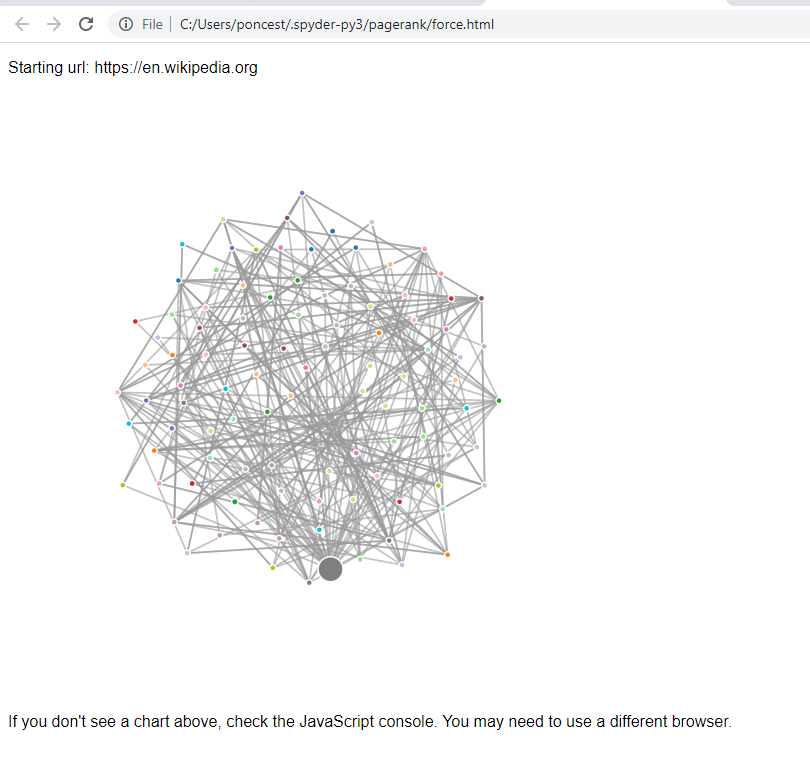


In [ ]:
# Filename = force.js


var width = 600,
    height = 600;

var color = d3.scale.category20();

var dist = (width + height) / 4;

var force = d3.layout.force()
    .charge(-120)
    .linkDistance(dist)
    .size([width, height]);

function getrank(rval) {
  return (rval/2.0) + 3;
}

function getcolor(rval) {
  return color(rval);
}

var svg = d3.select("#chart").append("svg")
    .attr("width", width)
    .attr("height", height);

function loadData(json) {
  force
      .nodes(json.nodes)
      .links(json.links);

    var k = Math.sqrt(json.nodes.length / (width * height));

    force
        .charge(-10 / k)
        .gravity(100 * k)
        .start();

  var link = svg.selectAll("line.link")
      .data(json.links)
      .enter().append("line")
      .attr("class", "link")
      .style("stroke-width", function(d) { return Math.sqrt(d.value); });

  var node = svg.selectAll("circle.node")
      .data(json.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", function(d) { return getrank(d.rank); } )
      .style("fill", function(d) { return getcolor(d.rank); })
      .on("dblclick",function(d) { 
            if ( confirm('Do you want to open '+d.url) ) 
                window.open(d.url,'_new',''); 
            d3.event.stopPropagation();
        })
      .call(force.drag);

  node.append("title")
      .text(function(d) { return d.url; });

  force.on("tick", function() {
    link.attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  });

}
loadData(spiderJson);



In [ ]:
# filename = force.html

<!DOCTYPE html>
<html>
  <head>
    <title>Force-Directed Layout</title>
    <script type="text/javascript" src="d3.v2.js"></script>
    <script type="text/javascript" src="spider.js"></script>
    <link type="text/css" rel="stylesheet" href="force.css"/>
  </head>
  <body style="font-family: sans-serif;">
    <script>
        document.write("<p>Starting url: "+spiderJson.nodes[0].url+"</p>");
    </script>
    <div id="chart" style="border:1px"></div>
    <script type="text/javascript" src="force.js"></script>
	<p>If you don't see a chart above, check the JavaScript console. You may
	need to use a different browser.</p>
  </body>
</html>


**Mailing List Data - Part I**


In this assignment you will download some of the mailing list data from http://mbox.dr-chuck.net/ and run the data cleaning / modeling process and take some screen shots. All screenshots should use the same data set.

Don't take off points for little mistakes. If they seem to have done the assignment give them full credit. Feel free to make suggestions if there are small mistakes. Please keep your comments positive and useful. The course staff will assign the last 30% of the grade and it make take a few days to get graded


In [ ]:


# 1) run gmane.py



import sqlite3
import time
import ssl
import urllib.request, urllib.parse, urllib.error
from urllib.parse import urljoin
from urllib.parse import urlparse
import re
from datetime import datetime, timedelta

# Not all systems have this so conditionally define parser
try:
    import dateutil.parser as parser
except:
    pass

def parsemaildate(md) :
    # See if we have dateutil
    try:
        pdate = parser.parse(tdate)
        test_at = pdate.isoformat()
        return test_at
    except:
        pass

    # Non-dateutil version - we try our best

    pieces = md.split()
    notz = " ".join(pieces[:4]).strip()

    # Try a bunch of format variations - strptime() is *lame*
    dnotz = None
    for form in [ '%d %b %Y %H:%M:%S', '%d %b %Y %H:%M:%S',
        '%d %b %Y %H:%M', '%d %b %Y %H:%M', '%d %b %y %H:%M:%S',
        '%d %b %y %H:%M:%S', '%d %b %y %H:%M', '%d %b %y %H:%M' ] :
        try:
            dnotz = datetime.strptime(notz, form)
            break
        except:
            continue

    if dnotz is None :
        # print 'Bad Date:',md
        return None

    iso = dnotz.isoformat()

    tz = "+0000"
    try:
        tz = pieces[4]
        ival = int(tz) # Only want numeric timezone values
        if tz == '-0000' : tz = '+0000'
        tzh = tz[:3]
        tzm = tz[3:]
        tz = tzh+":"+tzm
    except:
        pass

    return iso+tz

# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

conn = sqlite3.connect('content.sqlite')
cur = conn.cursor()

baseurl = "http://mbox.dr-chuck.net/sakai.devel/"

cur.execute('''CREATE TABLE IF NOT EXISTS Messages
    (id INTEGER UNIQUE, email TEXT, sent_at TEXT,
     subject TEXT, headers TEXT, body TEXT)''')

# Pick up where we left off
start = None
cur.execute('SELECT max(id) FROM Messages' )
try:
    row = cur.fetchone()
    if row is None :
        start = 0
    else:
        start = row[0]
except:
    start = 0

if start is None : start = 0

many = 0
count = 0
fail = 0
while True:
    if ( many < 1 ) :
        conn.commit()
        sval = input('How many messages:')
        if ( len(sval) < 1 ) : break
        many = int(sval)

    start = start + 1
    cur.execute('SELECT id FROM Messages WHERE id=?', (start,) )
    try:
        row = cur.fetchone()
        if row is not None : continue
    except:
        row = None

    many = many - 1
    url = baseurl + str(start) + '/' + str(start + 1)

    text = "None"
    try:
        # Open with a timeout of 30 seconds
        document = urllib.request.urlopen(url, None, 30, context=ctx)
        text = document.read().decode()
        if document.getcode() != 200 :
            print("Error code=",document.getcode(), url)
            break
    except KeyboardInterrupt:
        print('')
        print('Program interrupted by user...')
        break
    except Exception as e:
        print("Unable to retrieve or parse page",url)
        print("Error",e)
        fail = fail + 1
        if fail > 5 : break
        continue

    print(url,len(text))
    count = count + 1

    if not text.startswith("From "):
        print(text)
        print("Did not find From ")
        fail = fail + 1
        if fail > 5 : break
        continue

    pos = text.find("\n\n")
    if pos > 0 :
        hdr = text[:pos]
        body = text[pos+2:]
    else:
        print(text)
        print("Could not find break between headers and body")
        fail = fail + 1
        if fail > 5 : break
        continue

    email = None
    x = re.findall('\nFrom: .* <(\S+@\S+)>\n', hdr)
    if len(x) == 1 :
        email = x[0];
        email = email.strip().lower()
        email = email.replace("<","")
    else:
        x = re.findall('\nFrom: (\S+@\S+)\n', hdr)
        if len(x) == 1 :
            email = x[0];
            email = email.strip().lower()
            email = email.replace("<","")

    date = None
    y = re.findall('\Date: .*, (.*)\n', hdr)
    if len(y) == 1 :
        tdate = y[0]
        tdate = tdate[:26]
        try:
            sent_at = parsemaildate(tdate)
        except:
            print(text)
            print("Parse fail",tdate)
            fail = fail + 1
            if fail > 5 : break
            continue

    subject = None
    z = re.findall('\Subject: (.*)\n', hdr)
    if len(z) == 1 : subject = z[0].strip().lower();

    # Reset the fail counter
    fail = 0
    print("   ",email,sent_at,subject)
    cur.execute('''INSERT OR IGNORE INTO Messages (id, email, sent_at, subject, headers, body)
        VALUES ( ?, ?, ?, ?, ?, ? )''', ( start, email, sent_at, subject, hdr, body))
    if count % 50 == 0 : conn.commit()
    if count % 100 == 0 : time.sleep(1)

conn.commit()
cur.close()




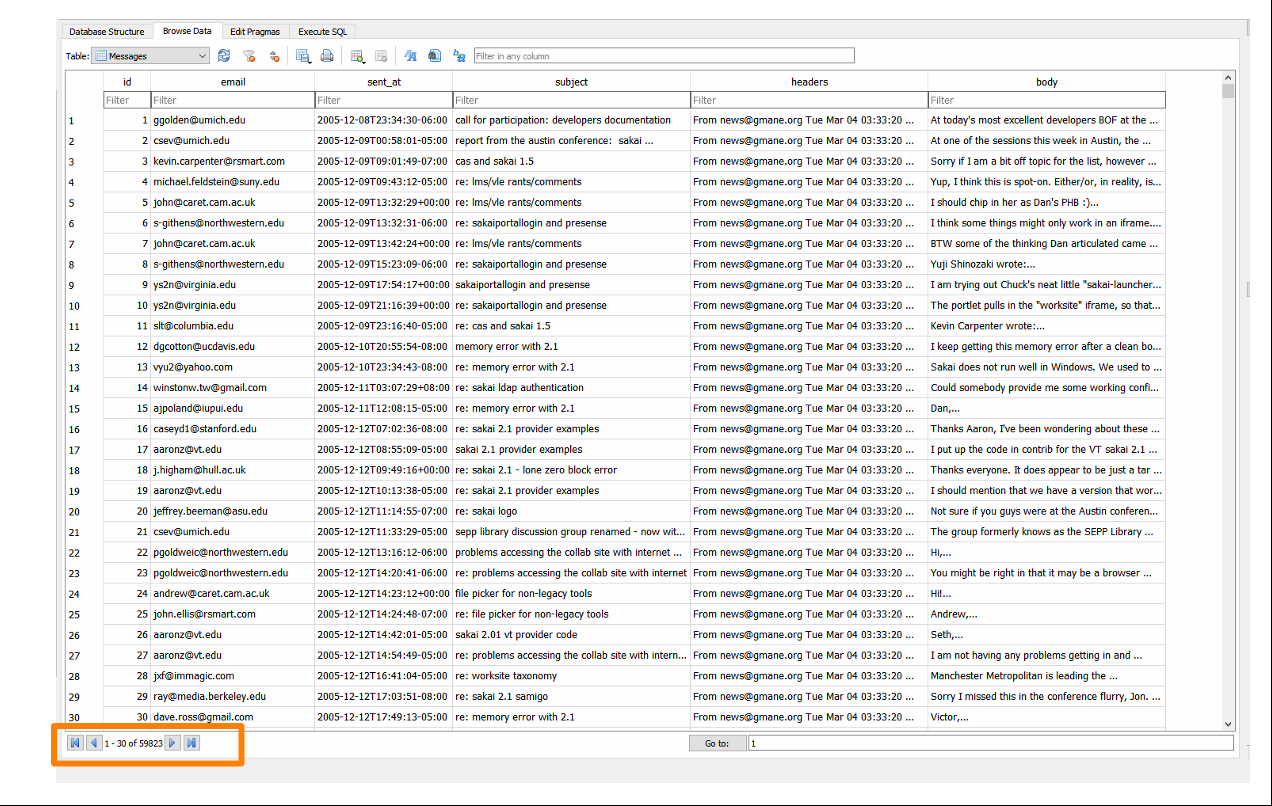


In [ ]:

# 2) run gmodel.py


import sqlite3
import time
import re
import zlib
from datetime import datetime, timedelta

# Not all systems have this
try:
    import dateutil.parser as parser
except:
    pass

dnsmapping = dict()
mapping = dict()

def fixsender(sender,allsenders=None) :
    global dnsmapping
    global mapping
    if sender is None : return None
    sender = sender.strip().lower()
    sender = sender.replace('<','').replace('>','')

    # Check if we have a hacked gmane.org from address
    if allsenders is not None and sender.endswith('gmane.org') :
        pieces = sender.split('-')
        realsender = None
        for s in allsenders:
            if s.startswith(pieces[0]) :
                realsender = sender
                sender = s
                # print(realsender, sender)
                break
        if realsender is None :
            for s in mapping:
                if s.startswith(pieces[0]) :
                    realsender = sender
                    sender = mapping[s]
                    # print(realsender, sender)
                    break
        if realsender is None : sender = pieces[0]

    mpieces = sender.split("@")
    if len(mpieces) != 2 : return sender
    dns = mpieces[1]
    x = dns
    pieces = dns.split(".")
    if dns.endswith(".edu") or dns.endswith(".com") or dns.endswith(".org") or dns.endswith(".net") :
        dns = ".".join(pieces[-2:])
    else:
        dns = ".".join(pieces[-3:])
    # if dns != x : print(x,dns)
    # if dns != dnsmapping.get(dns,dns) : print(dns,dnsmapping.get(dns,dns))
    dns = dnsmapping.get(dns,dns)
    return mpieces[0] + '@' + dns

def parsemaildate(md) :
    # See if we have dateutil
    try:
        pdate = parser.parse(md)
        test_at = pdate.isoformat()
        return test_at
    except:
        pass

    # Non-dateutil version - we try our best

    pieces = md.split()
    notz = " ".join(pieces[:4]).strip()

    # Try a bunch of format variations - strptime() is *lame*
    dnotz = None
    for form in [ '%d %b %Y %H:%M:%S', '%d %b %Y %H:%M:%S',
        '%d %b %Y %H:%M', '%d %b %Y %H:%M', '%d %b %y %H:%M:%S',
        '%d %b %y %H:%M:%S', '%d %b %y %H:%M', '%d %b %y %H:%M' ] :
        try:
            dnotz = datetime.strptime(notz, form)
            break
        except:
            continue

    if dnotz is None :
        # print('Bad Date:',md)
        return None

    iso = dnotz.isoformat()

    tz = "+0000"
    try:
        tz = pieces[4]
        ival = int(tz) # Only want numeric timezone values
        if tz == '-0000' : tz = '+0000'
        tzh = tz[:3]
        tzm = tz[3:]
        tz = tzh+":"+tzm
    except:
        pass

    return iso+tz

# Parse out the info...
def parseheader(hdr, allsenders=None):
    if hdr is None or len(hdr) < 1 : return None
    sender = None
    x = re.findall('\nFrom: .* <(\S+@\S+)>\n', hdr)
    if len(x) >= 1 :
        sender = x[0]
    else:
        x = re.findall('\nFrom: (\S+@\S+)\n', hdr)
        if len(x) >= 1 :
            sender = x[0]

    # normalize the domain name of Email addresses
    sender = fixsender(sender, allsenders)

    date = None
    y = re.findall('\nDate: .*, (.*)\n', hdr)
    sent_at = None
    if len(y) >= 1 :
        tdate = y[0]
        tdate = tdate[:26]
        try:
            sent_at = parsemaildate(tdate)
        except Exception as e:
            # print('Date ignored ',tdate, e)
            return None

    subject = None
    z = re.findall('\nSubject: (.*)\n', hdr)
    if len(z) >= 1 : subject = z[0].strip().lower()

    guid = None
    z = re.findall('\nMessage-ID: (.*)\n', hdr)
    if len(z) >= 1 : guid = z[0].strip().lower()

    if sender is None or sent_at is None or subject is None or guid is None :
        return None
    return (guid, sender, subject, sent_at)

conn = sqlite3.connect('index.sqlite')
cur = conn.cursor()

cur.execute('''DROP TABLE IF EXISTS Messages ''')
cur.execute('''DROP TABLE IF EXISTS Senders ''')
cur.execute('''DROP TABLE IF EXISTS Subjects ''')
cur.execute('''DROP TABLE IF EXISTS Replies ''')

cur.execute('''CREATE TABLE IF NOT EXISTS Messages
    (id INTEGER PRIMARY KEY, guid TEXT UNIQUE, sent_at INTEGER,
     sender_id INTEGER, subject_id INTEGER,
     headers BLOB, body BLOB)''')
cur.execute('''CREATE TABLE IF NOT EXISTS Senders
    (id INTEGER PRIMARY KEY, sender TEXT UNIQUE)''')
cur.execute('''CREATE TABLE IF NOT EXISTS Subjects
    (id INTEGER PRIMARY KEY, subject TEXT UNIQUE)''')
cur.execute('''CREATE TABLE IF NOT EXISTS Replies
    (from_id INTEGER, to_id INTEGER)''')

conn_1 = sqlite3.connect('mapping.sqlite')
cur_1 = conn_1.cursor()

cur_1.execute('''SELECT old,new FROM DNSMapping''')
for message_row in cur_1 :
    dnsmapping[message_row[0].strip().lower()] = message_row[1].strip().lower()

mapping = dict()
cur_1.execute('''SELECT old,new FROM Mapping''')
for message_row in cur_1 :
    old = fixsender(message_row[0])
    new = fixsender(message_row[1])
    mapping[old] = fixsender(new)

# Done with mapping.sqlite
conn_1.close()

# Open the main content (Read only)
conn_1 = sqlite3.connect('file:content.sqlite?mode=ro', uri=True)
cur_1 = conn_1.cursor()

allsenders = list()
cur_1.execute('''SELECT email FROM Messages''')
for message_row in cur_1 :
    sender = fixsender(message_row[0])
    if sender is None : continue
    if 'gmane.org' in sender : continue
    if sender in allsenders: continue
    allsenders.append(sender)

print("Loaded allsenders",len(allsenders),"and mapping",len(mapping),"dns mapping",len(dnsmapping))

cur_1.execute('''SELECT headers, body, sent_at
    FROM Messages ORDER BY sent_at''')

senders = dict()
subjects = dict()
guids = dict()

count = 0

for message_row in cur_1 :
    hdr = message_row[0]
    parsed = parseheader(hdr, allsenders)
    if parsed is None: continue
    (guid, sender, subject, sent_at) = parsed

    # Apply the sender mapping
    sender = mapping.get(sender,sender)

    count = count + 1
    if count % 250 == 1 : print(count,sent_at, sender)
    # print(guid, sender, subject, sent_at)

    if 'gmane.org' in sender:
        print("Error in sender ===", sender)

    sender_id = senders.get(sender,None)
    subject_id = subjects.get(subject,None)
    guid_id = guids.get(guid,None)

    if sender_id is None :
        cur.execute('INSERT OR IGNORE INTO Senders (sender) VALUES ( ? )', ( sender, ) )
        conn.commit()
        cur.execute('SELECT id FROM Senders WHERE sender=? LIMIT 1', ( sender, ))
        try:
            row = cur.fetchone()
            sender_id = row[0]
            senders[sender] = sender_id
        except:
            print('Could not retrieve sender id',sender)
            break
    if subject_id is None :
        cur.execute('INSERT OR IGNORE INTO Subjects (subject) VALUES ( ? )', ( subject, ) )
        conn.commit()
        cur.execute('SELECT id FROM Subjects WHERE subject=? LIMIT 1', ( subject, ))
        try:
            row = cur.fetchone()
            subject_id = row[0]
            subjects[subject] = subject_id
        except:
            print('Could not retrieve subject id',subject)
            break
    # print(sender_id, subject_id)
    cur.execute('INSERT OR IGNORE INTO Messages (guid,sender_id,subject_id,sent_at,headers,body) VALUES ( ?,?,?,datetime(?),?,? )',
            ( guid, sender_id, subject_id, sent_at,
            zlib.compress(message_row[0].encode()), zlib.compress(message_row[1].encode())) )
    conn.commit()
    cur.execute('SELECT id FROM Messages WHERE guid=? LIMIT 1', ( guid, ))
    try:
        row = cur.fetchone()
        message_id = row[0]
        guids[guid] = message_id
    except:
        print('Could not retrieve guid id',guid)
        break

cur.close()
cur_1.close()



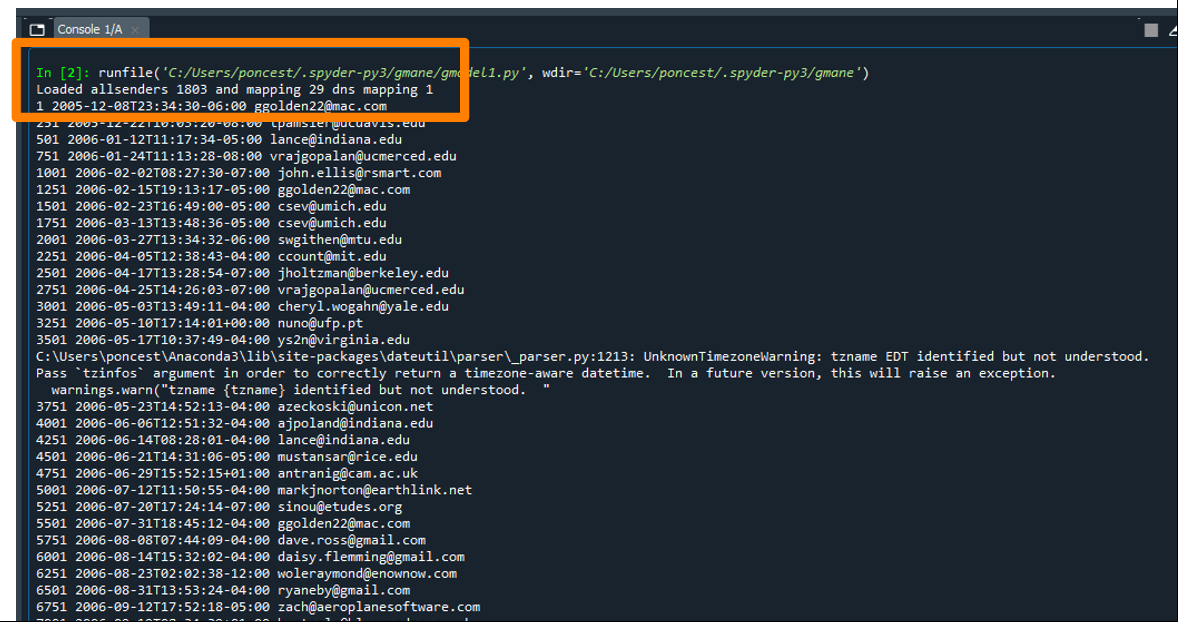


In [ ]:

# 3_ run gbasic.py


import sqlite3
import time
import zlib

howmany = int(input("How many to dump? "))

conn = sqlite3.connect('index.sqlite')
cur = conn.cursor()

cur.execute('SELECT id, sender FROM Senders')
senders = dict()
for message_row in cur :
    senders[message_row[0]] = message_row[1]

cur.execute('SELECT id, subject FROM Subjects')
subjects = dict()
for message_row in cur :
    subjects[message_row[0]] = message_row[1]

# cur.execute('SELECT id, guid,sender_id,subject_id,headers,body FROM Messages')
cur.execute('SELECT id, guid,sender_id,subject_id,sent_at FROM Messages')
messages = dict()
for message_row in cur :
    messages[message_row[0]] = (message_row[1],message_row[2],message_row[3],message_row[4])

print("Loaded messages=",len(messages),"subjects=",len(subjects),"senders=",len(senders))

sendcounts = dict()
sendorgs = dict()
for (message_id, message) in list(messages.items()):
    sender = message[1]
    sendcounts[sender] = sendcounts.get(sender,0) + 1
    pieces = senders[sender].split("@")
    if len(pieces) != 2 : continue
    dns = pieces[1]
    sendorgs[dns] = sendorgs.get(dns,0) + 1

print('')
print('Top',howmany,'Email list participants')

x = sorted(sendcounts, key=sendcounts.get, reverse=True)
for k in x[:howmany]:
    print(senders[k], sendcounts[k])
    if sendcounts[k] < 10 : break

print('')
print('Top',howmany,'Email list organizations')

x = sorted(sendorgs, key=sendorgs.get, reverse=True)
for k in x[:howmany]:
    print(k, sendorgs[k])
    if sendorgs[k] < 10 : break



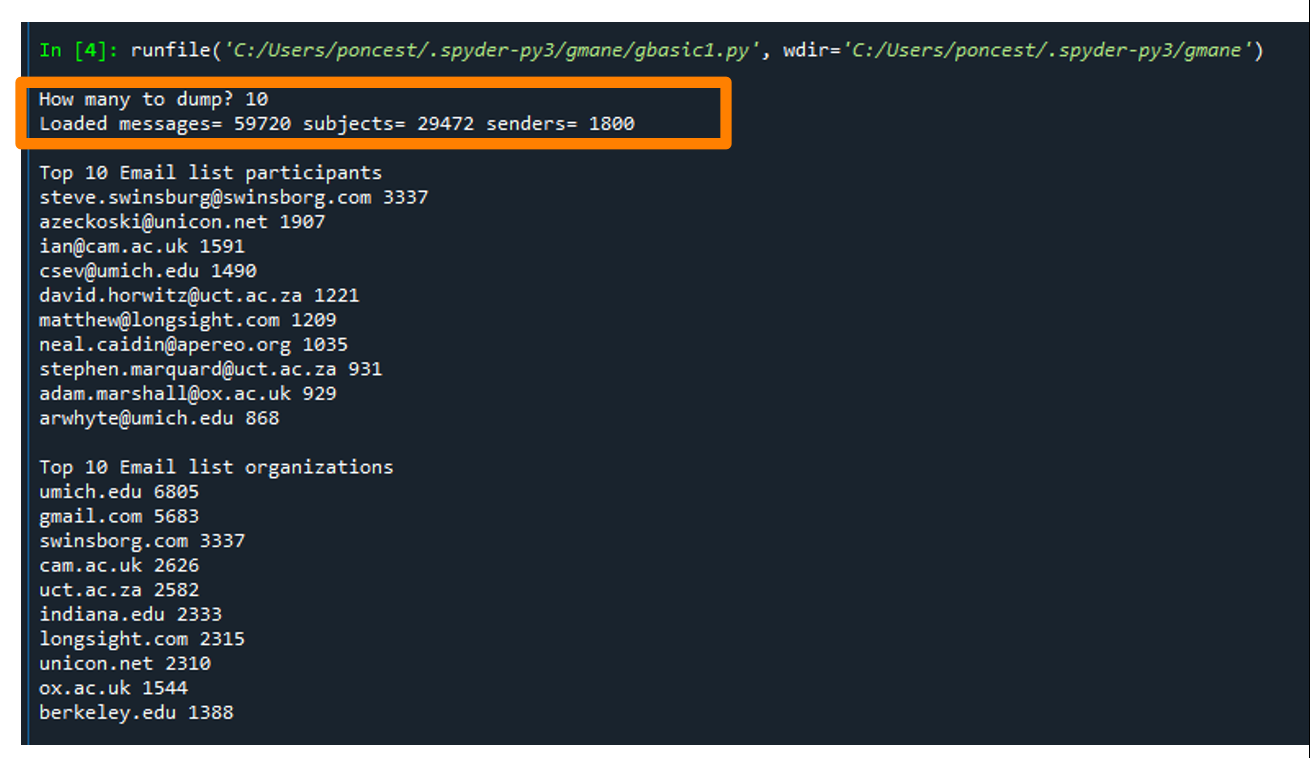



**Mailing List Data - Part II**


In this assignment you will visualize the mailing list data you have downloaded from http://mbox.dr-chuck.net/ and take some screen shots. Important: You do not have to download all of the data. Gbasic.py must use a count greater than 300. You can run gmane multiple times to download more messages. It is completely acceptable to visualize a small subset of the data in the gbasic screenshot. For the gbasic screenshot show the lines for dump?, loaded messages=, and both sections for Top Email list participants & Email list organizations. ***For students in mainland China that can't access the Google API for the timeline, take a screenshot of gline.js open in your editor showing the numbers, dates of messages at the top. Please add a note to your assignment.***

Don't take off points for little mistakes. If they seem to have done the assignment give them full credit. Feel free to make suggestions if there are small mistakes. Please keep your comments positive and useful. The course staff will assign the last 30% of the grade and it may take a few days to get graded.



In [ ]:


# 4_ run gword.py

import sqlite3
import time
import zlib
import string

conn = sqlite3.connect('index.sqlite')
cur = conn.cursor()

cur.execute('SELECT id, subject FROM Subjects')
subjects = dict()
for message_row in cur :
    subjects[message_row[0]] = message_row[1]

# cur.execute('SELECT id, guid,sender_id,subject_id,headers,body FROM Messages')
cur.execute('SELECT subject_id FROM Messages')
counts = dict()
for message_row in cur :
    text = subjects[message_row[0]]
    text = text.translate(str.maketrans('','',string.punctuation))
    text = text.translate(str.maketrans('','','1234567890'))
    text = text.strip()
    text = text.lower()
    words = text.split()
    for word in words:
        if len(word) < 4 : continue
        counts[word] = counts.get(word,0) + 1

x = sorted(counts, key=counts.get, reverse=True)
highest = None
lowest = None
for k in x[:100]:
    if highest is None or highest < counts[k] :
        highest = counts[k]
    if lowest is None or lowest > counts[k] :
        lowest = counts[k]
print('Range of counts:',highest,lowest)

# Spread the font sizes across 20-100 based on the count
bigsize = 80
smallsize = 20

fhand = open('gword.js','w')
fhand.write("gword = [")
first = True
for k in x[:100]:
    if not first : fhand.write( ",\n")
    first = False
    size = counts[k]
    size = (size - lowest) / float(highest - lowest)
    size = int((size * bigsize) + smallsize)
    fhand.write("{text: '"+k+"', size: "+str(size)+"}")
fhand.write( "\n];\n")
fhand.close()

print("Output written to gword.js")
print("Open gword.htm in a browser to see the vizualization")



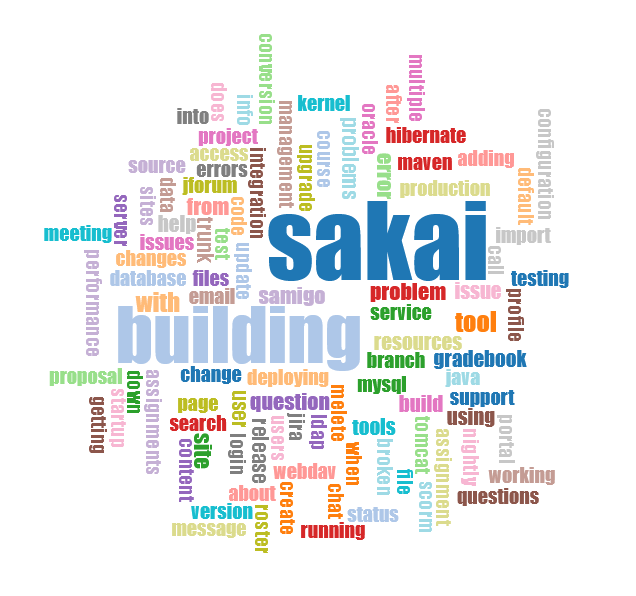


In [ ]:

# 5_ run gline.py

import sqlite3
import time
import zlib

conn = sqlite3.connect('index.sqlite')
cur = conn.cursor()

cur.execute('SELECT id, sender FROM Senders')
senders = dict()
for message_row in cur :
    senders[message_row[0]] = message_row[1]

cur.execute('SELECT id, guid,sender_id,subject_id,sent_at FROM Messages')
messages = dict()
for message_row in cur :
    messages[message_row[0]] = (message_row[1],message_row[2],message_row[3],message_row[4])

print("Loaded messages=",len(messages),"senders=",len(senders))

sendorgs = dict()
for (message_id, message) in list(messages.items()):
    sender = message[1]
    pieces = senders[sender].split("@")
    if len(pieces) != 2 : continue
    dns = pieces[1]
    sendorgs[dns] = sendorgs.get(dns,0) + 1

# pick the top schools
orgs = sorted(sendorgs, key=sendorgs.get, reverse=True)
orgs = orgs[:10]
print("Top 10 Organizations")
print(orgs)

counts = dict()
months = list()
# cur.execute('SELECT id, guid,sender_id,subject_id,sent_at FROM Messages')
for (message_id, message) in list(messages.items()):
    sender = message[1]
    pieces = senders[sender].split("@")
    if len(pieces) != 2 : continue
    dns = pieces[1]
    if dns not in orgs : continue
    month = message[3][:7]
    if month not in months : months.append(month)
    key = (month, dns)
    counts[key] = counts.get(key,0) + 1

months.sort()
# print counts
# print months

fhand = open('gline.js','w')
fhand.write("gline = [ ['Month'")
for org in orgs:
    fhand.write(",'"+org+"'")
fhand.write("]")

for month in months:
    fhand.write(",\n['"+month+"'")
    for org in orgs:
        key = (month, org)
        val = counts.get(key,0)
        fhand.write(","+str(val))
    fhand.write("]");

fhand.write("\n];\n")
fhand.close()

print("Output written to gline.js")
print("Open gline.htm to visualize the data")



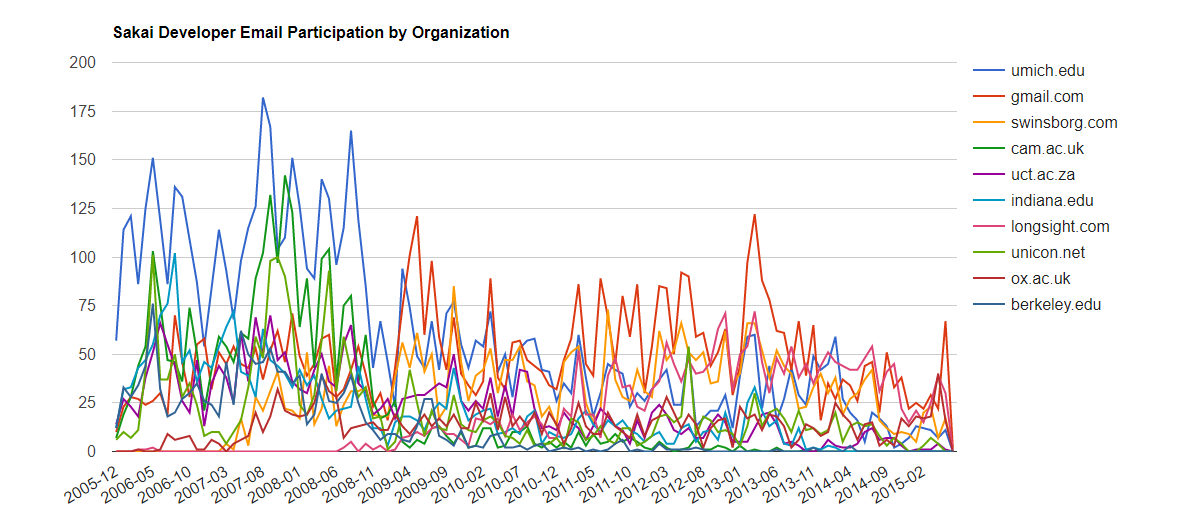


In [ ]:

# 6_ run gline.py
# modify code to plot by year

import sqlite3
import time
import zlib

conn = sqlite3.connect('index.sqlite')
cur = conn.cursor()

cur.execute('SELECT id, sender FROM Senders')
senders = dict()
for message_row in cur :
    senders[message_row[0]] = message_row[1]

cur.execute('SELECT id, guid,sender_id,subject_id,sent_at FROM Messages')
messages = dict()
for message_row in cur :
    messages[message_row[0]] = (message_row[1],message_row[2],message_row[3],message_row[4])

print("Loaded messages=",len(messages),"senders=",len(senders))

sendorgs = dict()
for (message_id, message) in list(messages.items()):
    sender = message[1]
    pieces = senders[sender].split("@")
    if len(pieces) != 2 : continue
    dns = pieces[1]
    sendorgs[dns] = sendorgs.get(dns,0) + 1

# pick the top schools
orgs = sorted(sendorgs, key=sendorgs.get, reverse=True)
orgs = orgs[:10]
print("Top 10 Organizations")
print(orgs)

counts = dict()
years = list()
# cur.execute('SELECT id, guid,sender_id,subject_id,sent_at FROM Messages')
for (message_id, message) in list(messages.items()):
    sender = message[1]
    pieces = senders[sender].split("@")
    if len(pieces) != 2 : continue
    dns = pieces[1]
    if dns not in orgs : continue
    year = message[3][:4]
    if year not in years : years.append(year)
    key = (year, dns)
    counts[key] = counts.get(key,0) + 1

years.sort()
# print counts
# print months

fhand = open('gline.js','w')
fhand.write("gline = [ ['Month'")
for org in orgs:
    fhand.write(",'"+org+"'")
fhand.write("]")

for year in years:
    fhand.write(",\n['"+year+"'")
    for org in orgs:
        key = (year, org)
        val = counts.get(key,0)
        fhand.write(","+str(val))
    fhand.write("]");

fhand.write("\n];\n")
fhand.close()

print("Output written to gline.js")
print("Open gline.htm to visualize the data")



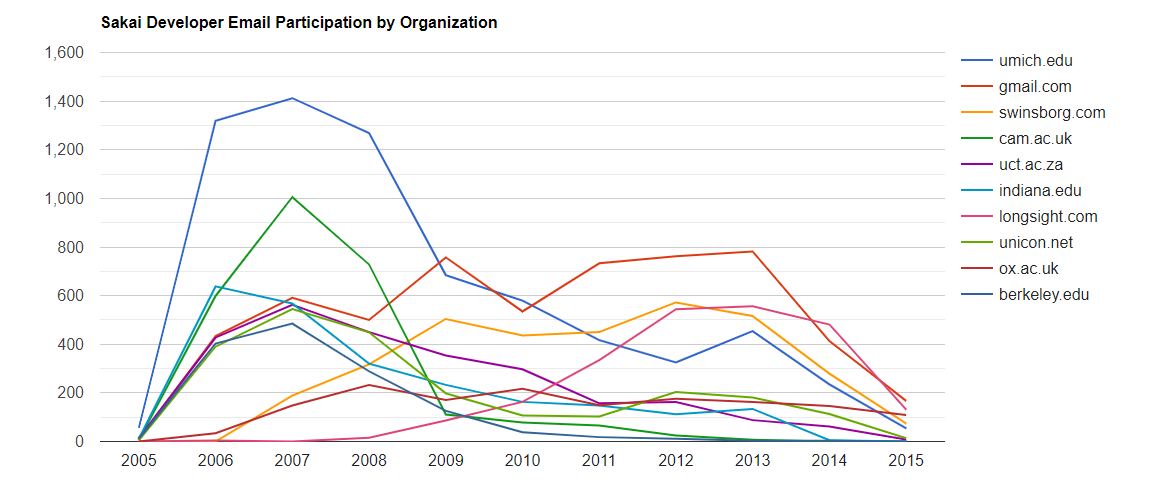
